In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense, Flatten, Activation, Dropout, BatchNormalization, AvgPool2D, MaxPool2D
from tensorflow.keras.metrics import categorical_crossentropy
from keras.optimizers import Adam
import cv2

In [3]:
data = "/content/drive/MyDrive/brain_tumor_dataset"
no_tumor = "/content/drive/MyDrive/brain_tumor_dataset/no"
yes_tumor = "/content/drive/MyDrive/brain_tumor_dataset/yes"

In [4]:
files = [no_tumor,yes_tumor]
classes = ['no','yes']
all_files_path = []
all_labels = []

for i,j in zip(files, classes):
  file_list = os.listdir(i)
  #print(len(file_list))
  for f in file_list:
    file_path = os.path.join(i,f)
    all_files_path.append(file_path)
    all_labels.append(j)
print("Length of filepaths is {} and total labels are {}".format(len(all_files_path), len(all_labels)))

Length of filepaths is 253 and total labels are 253


In [5]:
path_df = pd.DataFrame(all_files_path, columns=['file_path'])
labels_df = pd.DataFrame(all_labels, columns=['label'])
df = pd.concat([path_df, labels_df], axis=1)
df

,file_path,label
0,/content/drive/MyDrive/brain_tumor_dataset/no/...,no
1,/content/drive/MyDrive/brain_tumor_dataset/no/...,no
2,/content/drive/MyDrive/brain_tumor_dataset/no/...,no
3,/content/drive/MyDrive/brain_tumor_dataset/no/...,no
4,/content/drive/MyDrive/brain_tumor_dataset/no/...,no
...,...,...
248,/content/drive/MyDrive/brain_tumor_dataset/yes...,yes
249,/content/drive/MyDrive/brain_tumor_dataset/yes...,yes
250,/content/drive/MyDrive/brain_tumor_dataset/yes...,yes
251,/content/drive/MyDrive/brain_tumor_dataset/yes...,yes


In [6]:
df['label'].value_counts()

yes    155
no      98
Name: label, dtype: int64

In [7]:
df['file_path'][3]

'/content/drive/MyDrive/brain_tumor_dataset/no/No21.jpg'

In [8]:
num = np.random.randint(1, len(df))
num
#df.loc[3,'file_path']

57

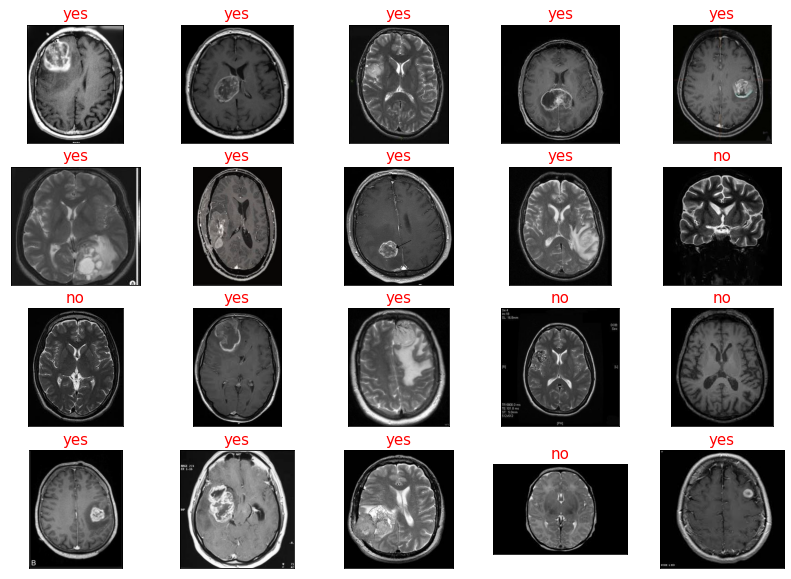

In [9]:
plt.figure(figsize=(14,10))
for i in range(20):
  num = np.random.randint(1, len(df))
  plt.subplot(4,5,i+1)
  img = cv2.imread(df['file_path'][num])
  plt.imshow(img)
  plt.title(df['label'][num], size=15, color='red')
  plt.xticks([])
  plt.yticks([])
plt.show()

Train Test Split

In [10]:
from sklearn.model_selection import train_test_split

train_valid, test = train_test_split(df, test_size=0.1, random_state=11)
train, valid = train_test_split(train_valid, test_size=0.1, random_state=11)

print(f"Train shape: {train.shape}\n Test shape: {test.shape}\n Valid shape: {valid.shape}")

Train shape: (204, 2)
 Test shape: (26, 2)
 Valid shape: (23, 2)


In [11]:
train_datagen = ImageDataGenerator(rescale=1./255., rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.1,
                                   brightness_range=(0.25,1.2), zoom_range=0.3, horizontal_flip=True, vertical_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255.)

`flow_from_dataframe` function of Keras `ImageDataGenerator` class loads the image dataset in memory and generates batches of **augmented/normalized data.**

In [12]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
x_col="file_path",
y_col="label",
target_size=(224,224),                   #dimensions to which all images found will be resized.
batch_size=32,
seed=42,
shuffle=True,
class_mode="binary")

Found 204 validated image filenames belonging to 2 classes.


In [13]:
img.shape

(219, 230, 3)

In [14]:
valid_generator=train_datagen.flow_from_dataframe(
dataframe=valid,
x_col="file_path",
y_col="label",
target_size=(224,224),                   #dimensions to which all images found will be resized.
batch_size=16,
seed=42,
shuffle=True,
class_mode="binary")

Found 23 validated image filenames belonging to 2 classes.


In [15]:
test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
x_col="file_path",
y_col="label",
target_size=(224,224),                   #dimensions to which all images found will be resized.
batch_size=16,
seed=42,
shuffle=False,
class_mode="binary")

Found 26 validated image filenames belonging to 2 classes.


In [16]:
train_generator.class_indices

{'no': 0, 'yes': 1}

Transfer Learning using **Inception ResNetV2**

In [17]:
from keras.layers.serialization import activation
from tensorflow import keras
base_model = keras.applications.ResNet50V2(
    weights = "imagenet",
    input_shape = (224, 224, 3),
    include_top = False            #top layers means the fully connected layers, we don't use the ImageNet Classifier at the top
)

#Freezing the base model
base_model.trainable = False


# Let's print the layers of the base model
for i,layer in enumerate(base_model.layers):
  print(str(i) + "layer " + layer.__class__.__name__, "is trainable :", layer.trainable)



94668760/94668760 [==============================] - 7s 0us/step
0layer InputLayer is trainable : False
1layer ZeroPadding2D is trainable : False
2layer Conv2D is trainable : False
3layer ZeroPadding2D is trainable : False
4layer MaxPooling2D is trainable : False
5layer BatchNormalization is trainable : False
6layer Activation is trainable : False
7layer Conv2D is trainable : False
8layer BatchNormalization is trainable : False
9layer Activation is trainable : False
10layer ZeroPadding2D is trainable : False
11layer Conv2D is trainable : False
12layer BatchNormalization is trainable : False
13layer Activation is trainable : False
14layer Conv2D is trainable : False
15layer Conv2D is trainable : False
16layer Add is trainable : False
17layer BatchNormalization is trainable : False
18layer Activation is trainable : False
19layer Conv2D is trainable : False
20layer BatchNormalization is trainable : False
21layer Activation is trainable : False
22layer ZeroPadding2D is trainable : False
23

In [30]:
# Create a new model on top
input = keras.Input(shape=(224,224,3))

#x=base_model.output                                 # Output shape=(batch_size, 7, 7, 2048)
x = base_model(input, training=False)
#GlobalAveragePooling2D: pooling the average value of each feature map and stack along the depth
x = keras.layers.GlobalAveragePooling2D()(x)        #input shape=(batch_size,h,w,channels)  output shape = (batch_size,1,1,channels)
# shape is now (batch_size, 1,1,2048)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.15)(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.15)(x)
output = keras.layers.Dense(1, activation="sigmoid")(x)
model =  keras.Model(inputs = input, outputs = output)
#model = keras.Model(inputs = base_model.input, outputs= output)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                           

In [33]:
# Create a new model on top
#input = keras.Input(shape=(224,224,3))

x=base_model.output                                 # Output shape=(batch_size, 7, 7, 2048)
#x = base_model(input, training=False)
#GlobalAveragePooling2D: pooling the average value of each feature map and stack along the depth
x = keras.layers.GlobalAveragePooling2D()(x)        #input shape=(batch_size,h,w,channels)  output shape = (batch_size,1,1,channels)
# shape is now (batch_size, 1,1,2048)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
output = keras.layers.Dense(1, activation="sigmoid")(x)
#model =  keras.Model(input, output)
model = keras.Model(inputs = base_model.input, outputs= output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [31]:
callbacks = [tf.keras.callbacks.ModelCheckpoint("brain_tumor_model.h5", save_best_only=True, verbose=1)]

In [32]:
model.compile(loss = "binary_crossentropy", optimizer = Adam(learning_rate=0.0001), metrics=['accuracy'])
history = model.fit(train_generator, validation_data=valid_generator, epochs=200, callbacks= [callbacks], verbose=1)

Epoch 1/200
7/7 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.6078
Epoch 1: val_loss improved from inf to 0.56750, saving model to brain_tumor_model.h5
7/7 [==============================] - 8s 806ms/step - loss: 0.6805 - accuracy: 0.6078 - val_loss: 0.5675 - val_accuracy: 0.8696
Epoch 2/200
7/7 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.7353
Epoch 2: val_loss improved from 0.56750 to 0.54571, saving model to brain_tumor_model.h5
7/7 [==============================] - 4s 636ms/step - loss: 0.5503 - accuracy: 0.7353 - val_loss: 0.5457 - val_accuracy: 0.7826
Epoch 3/200
7/7 [==============================] - ETA: 0s - loss: 0.4616 - accuracy: 0.7794
Epoch 3: val_loss improved from 0.54571 to 0.44376, saving model to brain_tumor_model.h5
7/7 [==============================] - 5s 656ms/step - loss: 0.4616 - accuracy: 0.7794 - val_loss: 0.4438 - val_accuracy: 0.7826
Epoch 4/200
7/7 [==============================] - ETA: 0s - loss: 0.40

In [33]:
model.save("/content/drive/MyDrive/brain_tumor_dataset/brain_tumor_model.h5")

Evaluating our model

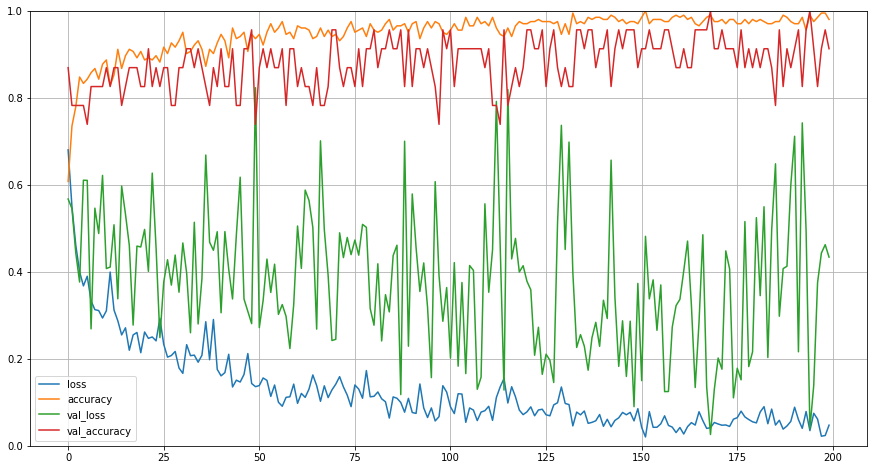

In [35]:
pd.DataFrame(history.history).plot(figsize=(15,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [48]:
from PIL import Image
model_path = "/content/drive/MyDrive/brain_tumor_dataset/brain_tumor_model.h5"
loaded_model = tf.keras.models.load_model(model_path)

import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread("/content/drive/MyDrive/brain_tumor_dataset/no/14 no.jpg")
#image = cv2.imread("/content/drive/MyDrive/brain_tumor_dataset/yes/Y101.jpg")

image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((224, 224))
expand_input = np.expand_dims(resize_image,axis=0)
input_data = np.array(expand_input)
input_data = input_data/255

pred = loaded_model.predict(input_data)
if pred >= 0.5:
  print("Tumor present.")
else:
  print("Tumor absent.")

1/1 [==============================] - 1s 894ms/step
Tumor absent.
